## Understanding Employee Attrition: Identifying Trends and Reducing Turnover ##

## *What is Attrition?*
Employee attrition refers to the departure of an employee from a company for any reason. Involuntary attrition occurs when employees are terminated due to factors such as inadequate performance or business mandates, whereas voluntary attrition is the phenomenon of often high performing employees choosing to leave on their own volition.(CITE2) Although voluntary departures can result from retirement and other personal reasons, they are frequently driven by workplace-related factors such as low job satisfaction or lack of finanacial compensation. 

High attrition rates are problematic not only because of the loss of talent and experience a seasoned employee may contribute, but also due to the emotional and financial impact on these organizations; Remaining coworkers may have lower morale leading to a less positive working environment and lower productivity.(CITE1) Additionally, the cost and time of interviewing, hiring, and training a replacement will likely be substantial.(CITE1) Therefore, understanding what leads an employee to attrit is crucial for a company to prevent these potential losses.

This study aims to answer two questions:\
**1)** What are the factors influencing employee attrition?\
**2)** How can predictive models created with these factors in mind be used to prevent high turnover rates?

This study utilizes a dataset which explores various factors that could influence whether an employee decides to stay with or leave a company. This dataset contains 1,470 observations and 35 factors, including information about demographics, job role, salary, satisfaction levels, and performance. The data originates from a HR analytics setting aimed at understanding employee attrition patterns.

The dataset: https://www.kaggle.com/datasets/rishikeshkonapure/hr-analytics-prediction/

CITATIONS USED! can someone else cite\
https://scholar.smu.edu/cgi/viewcontent.cgi?article=1010&context=datasciencereview(1)(link isnt vald, smu data science review volumne 1 titled "Employee Attrition: What Mak ttrition: What Makes an Emplo es an Employee Quit? ee Quit? ")
https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8605976(2) 


In [1]:
library(tidyverse)
library(dplyr)
library(GGally)
library(reshape2)
library(glmnet)
library(tidymodels)
library(caret)
library(pROC)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2


Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths


Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-8

── Attaching packages ────────────────────────────────────── tidymodels 1.2.0 ──

✔ broom        1.0.6     ✔ rsample      1.2.

# The Data #

In [2]:
hr_attrition <- read_csv("data/HR-Employee-Attrition.csv")
head(hr_attrition)

Rows: 1470 Columns: 35
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (9): Attrition, BusinessTravel, Department, EducationField, Gender, Job...
dbl (26): Age, DailyRate, DistanceFromHome, Education, EmployeeCount, Employ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Age Attrition BusinessTravel    DailyRate Department            
1 41  Yes       Travel_Rarely     1102      Sales                 
2 49  No        Travel_Frequently  279      Research & Development
3 37  Yes       Travel_Rarely     1373      Research & Development
4 33  No        Travel_Frequently 1392      Research & Development
5 27  No        Travel_Rarely      591      Research & Development
6 32  No        Travel_Frequently 1005      Research & Development
  DistanceFromHome Education EducationField EmployeeCount EmployeeNumber ⋯
1 1                2         Life Sciences  1             1              ⋯
2 8                1         Life Sciences  1             2              ⋯
3 2                2         Other          1             4              ⋯
4 3                4         Life Sciences  1             5              ⋯
5 2                1         Medical        1             7              ⋯
6 2                2         Life Sciences  1             8              ⋯
  RelationshipSatisfaction StandardHours StockOptionLevel TotalWorkingYears
1 1                        80            0                 8               
2 4                        80            1                10               
3 2                        80            0                 7               
4 3                        80            0                 8               
5 4                        80            1                 6               
6 3                        80            0                 8               
  TrainingTimesLastYear WorkLifeBalance YearsAtCompany YearsInCurrentRole
1 0                     1                6             4                 
2 3                     3               10             7                 
3 3                     3                0             0                 
4 3                     3                8             7                 
5 3                     3                2             2                 
6 2                     2                7             7                 
  YearsSinceLastPromotion YearsWithCurrManager
1 0                       5                   
2 1                       7                   
3 0                       0                   
4 3                       0                   
5 2                       2                   
6 3                       6

The response variable of this dataset `Attrition` is a binary variable indicating whether or not an employee has "attrited" or not where
$$
f(x) =
\begin{cases}
1 \; \; \; \; \mbox{if the employee has left the company}\\
0 \; \; \; \; 	\mbox{otherwise}
\end{cases}
$$

The input variables are categorized as follows:

**Demographic Information**
- `Age`: Age in years
- `Gender`: Gender of the employee (Male/Female)
- `MaritalStatus`: Relationship Status of employee with 3 levels (Married, Single, other)
- `Over18`: Whether the employee is over 18 (Y/N)
- `EmployeeNumber`: A unique combination of 4 digits assigned to every employee
- `Education`: A numerical representation of level of education: 1-"below college", 2-"college", 3-"bachelors", 4-"masters", 5-"doctor"
- `EducationField`: Stream of education of employee (Life sciences, Medical, Human resources, Marketing, Technical degree, other)
- `EmployeeCount`: Employee count (constant, 1)

**Work Environment**

- `BusinessTravel`: How frequently the employee travels for work with 3 levels (Rarely, Frequently, none)
- `Department`: Department of an employee (Research & Development, Sales, Human resources)
- `JobInvolvement`: Level of involvement of employee with 1 being low, 4 being the highest involvement
- `JobLevel`: Level of job of employee between 1-5
- `JobRole`: Role of employee (Sales executive, Healthcare representative, Human resources, Laboratory Technician, Manager, Manufacturing director, Research director, Research scientist, Sales representative)
- `JobSatisfaction`: How satisfied employee is with job where 1 is low satisfaction and 4 is highest
- `PerformanceRating`: Rating given to employee based on performance (3/4)
- `TotalWorkingYears`: Total years employee spent working 
- `YearsAtCompany`: Total years employee spent working at this company
- `YearsInCurrentRole`: Number of years spent at current role 
- `YearsSinceLastPromotion`: Number of years since employee was last promoted
- `YearsWithCurrManager`: Number of years spend working under current manager 
- `NumCompaniesWorked`: Number of companies the employee has worked for
- `RelationshipSatisfaction`: Level of satisfaction working with other colleauges between 1-4
- `EnvironmentSatisfaction`: Level of satisfaction with working environment between 1-4

**Financial Compensation**
- `DailyRate`: Daily wage of an employee in dollars 
- `MonthlyIncome`: Monthly income of employee in dollars
- `MonthlyRate`: Monthly fixed rate of employee in dollars
- `OverTime`: Binary representation of whether the employee works overtime (Yes/No)
- `PercentSalaryHike`: Percentage of salary increase while employed 
- `StockOptionLevel`: Level of stock options granted to employee between 0-3

**Work-life Balance** 
- `DistanceFromHome`: Distance from home to office in kilometers
- `WorkLifeBalance`: Level of work-life balanced achieved between 1-4
- `TrainingTimesLastYear`: Number of hours employee spent in training sessions in the previous year
- `StandardHours` : Number of hours worked per week

In exploring this dataset, a subset of variables are chosen that we suspect have a significant impact on attrition. These variables have been chosen to keep the model both understandable and effective, avoiding complex interactions and high correlation issues present in the full dataset. Although variables such as `StockOptionLevel` may have an impact, they lack interpretability compared to more intuitive features like `MonthlyIncome`. By limiting the model to only key variables from these categories, this study aims to hopefully investigate clear and straightforward relationships that still capture the essential patterns in the data.

The key predictors we will be focusing on are as follows:

`Age`: Older employees may be more likely to stay or leave depending on career goals.\
`MonthlyIncome`: Lower income might increase the likelihood of attrition.\
`JobSatisfaction`: Dissatisfied employees may be more likely to leave.\
`WorkLifeBalance`: Poor balance could lead to higher attrition rates.\
`OverTime`: Employees working overtime frequently might experience burnout.\
`YearsAtCompany`: Employees with shorter tenures might leave more frequently.\
`DistanceFromHome`: A long commute could influence attrition.

It is important to keep in mind that with this particular combination of variables there are many different ways to possibly interpret the relationship between them and the response, as well as how they impact eachother. For example, one would expect an employee with low job satisfaction to attrit, but if that same employee had worked for the company for many years, then they might feel loyalty towards the company. At the same time, this would probably change depending on that same employee's monthly income—perhaps someone with a higher monthly income would stay for the benifits, while an employee who has been working for a company for a long time yet still has a relatively low monthly income would be more likely to attrit. There are also generally patterns such as an older employees having greater monthly income. Obviously this prompts heavy evaluation of the variables in order to combat multicollinearity and the consideration of potential interaction terms. 

In [3]:
# Main: Divij
#check for null values
colSums(is.na(hr_attrition))

# Main: Divij
# Contributor: Yuko
# Make all categorical variables factors 
# Mutate attrition to 1/0 for logistic regression prep and get rid of Employee Count since its constant
hr_attrition <- hr_attrition %>% 
    mutate(Attrition = if_else(Attrition == "Yes", 1, 0)) %>%
    select(-EmployeeCount)

categorical_cols <- c("Attrition", "WorkLifeBalance", "JobSatisfaction", "OverTime", "PerformanceRating", 
                      "Gender", "MaritalStatus", "Over18", "Education", "EducationField", 
                      "BusinessTravel", "Department", "JobInvolvement", "JobRole", "JobLevel", 
                      "RelationshipSatisfaction", "EnvironmentSatisfaction", "StockOptionLevel")
hr_attrition[categorical_cols] <- lapply(hr_attrition[categorical_cols], as.factor)

levels(hr_attrition$WorkLifeBalance) #check that they are successfully factors
dim(hr_attrition) # should be 1470 x 34 now

Age                Attrition           BusinessTravel 
                       0                        0                        0 
               DailyRate               Department         DistanceFromHome 
                       0                        0                        0 
               Education           EducationField            EmployeeCount 
                       0                        0                        0 
          EmployeeNumber  EnvironmentSatisfaction                   Gender 
                       0                        0                        0 
              HourlyRate           JobInvolvement                 JobLevel 
                       0                        0                        0 
                 JobRole          JobSatisfaction            MaritalStatus 
                       0                        0                        0 
           MonthlyIncome              MonthlyRate       NumCompaniesWorked 
                       0                        0                        0 
                  Over18                 OverTime        PercentSalaryHike 
                       0                        0                        0 
       PerformanceRating RelationshipSatisfaction            StandardHours 
                       0                        0                        0 
        StockOptionLevel        TotalWorkingYears    TrainingTimesLastYear 
                       0                        0                        0 
         WorkLifeBalance           YearsAtCompany       YearsInCurrentRole 
                       0                        0                        0 
 YearsSinceLastPromotion     YearsWithCurrManager 
                       0                        0

[1] "1" "2" "3" "4"

[1] 1470   34

There are no null values so there is minimal clean up of the dataset.

In [5]:
# Main: Yuko  
# Select the variables of interest
hr_attrition_subset <- hr_attrition %>% 
    select(Attrition,
           Age, 
           YearsAtCompany,
           OverTime, 
           DistanceFromHome,
           WorkLifeBalance, 
           JobSatisfaction,
           MonthlyIncome)
head(hr_attrition_subset)

Attrition Age YearsAtCompany OverTime DistanceFromHome WorkLifeBalance
1 1         41   6             Yes      1                1              
2 0         49  10             No       8                3              
3 1         37   0             Yes      2                3              
4 0         33   8             Yes      3                3              
5 0         27   2             No       2                3              
6 0         32   7             No       2                2              
  JobSatisfaction MonthlyIncome
1 4               5993         
2 2               5130         
3 3               2090         
4 3               2909         
5 2               3468         
6 4               3068

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwid

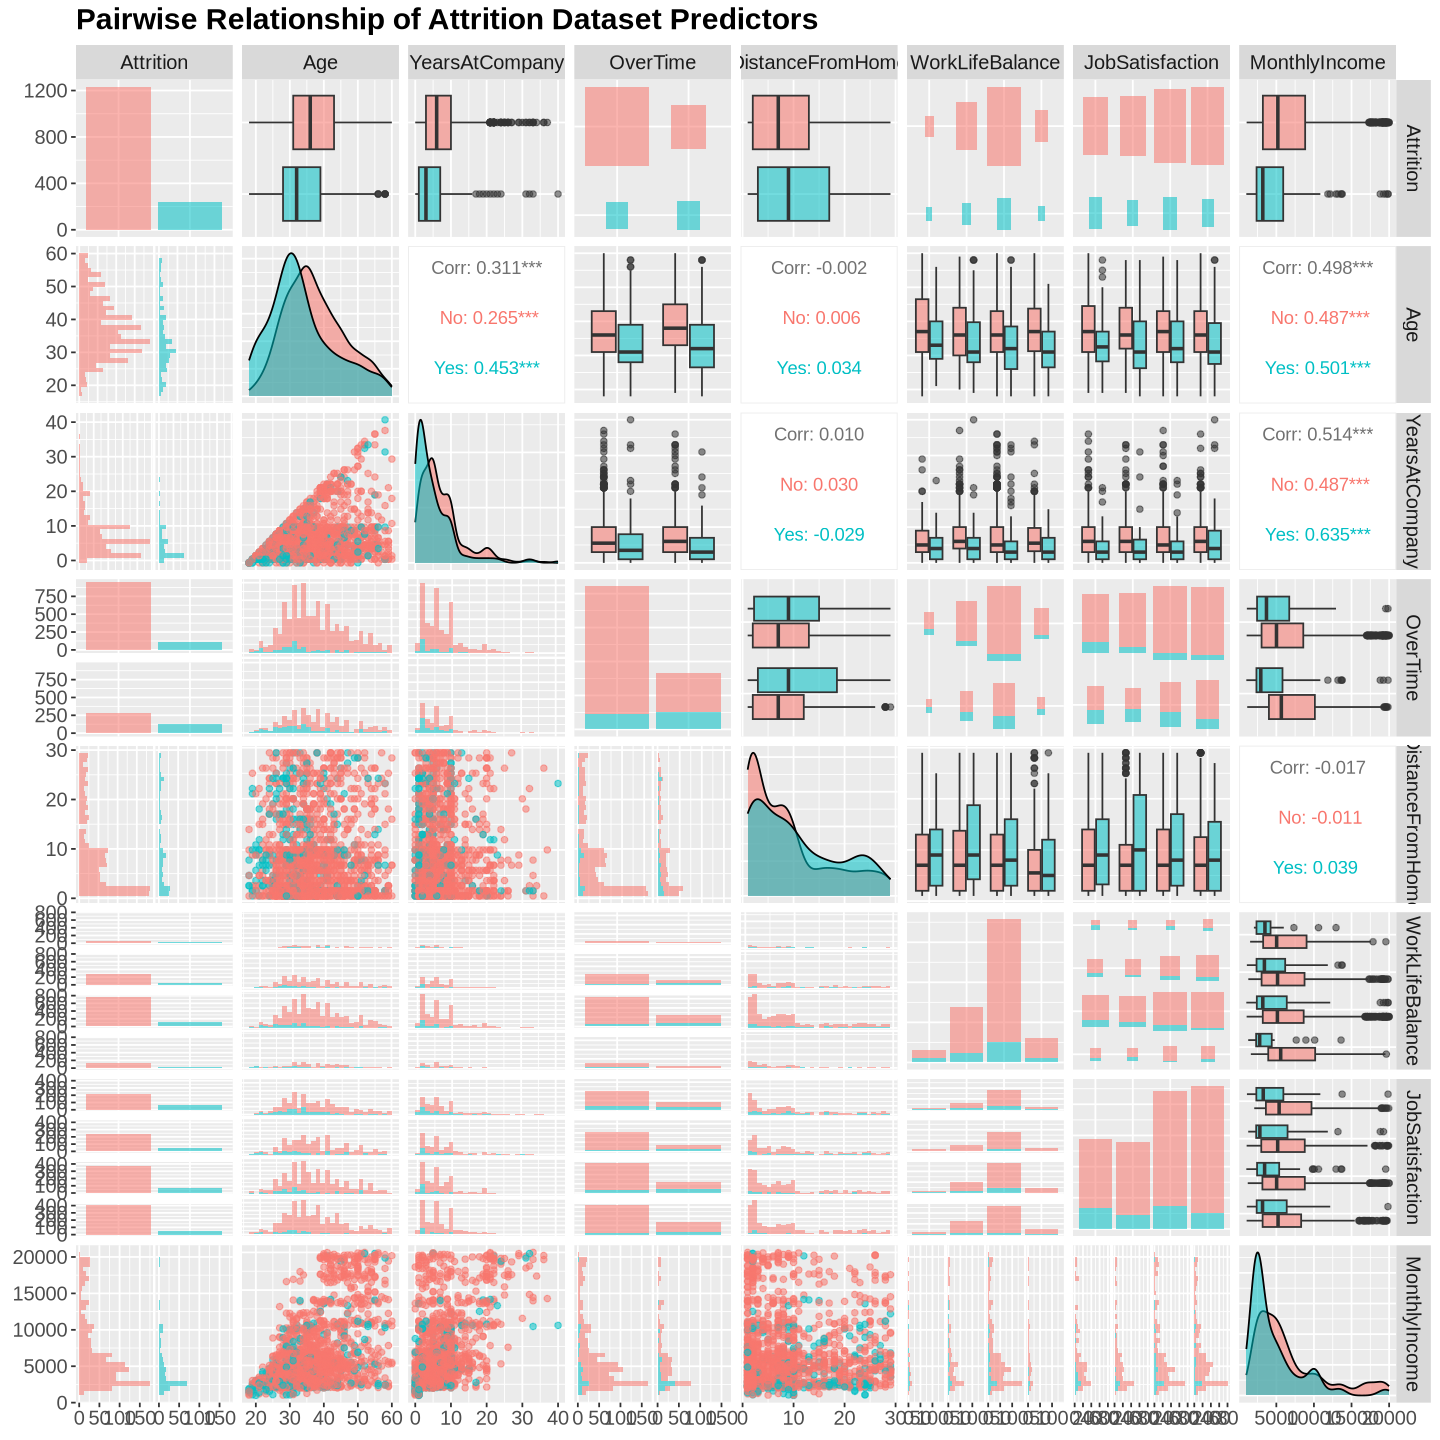

In [40]:
options(repr.plot.width = 12, repr.plot.height = 12) 
# Plot a pairwise plot of all of the important variables
# Main: Divij 
# Contributor: Yuko
pairs_plot <- hr_attrition_subset %>%
    ggpairs(aes(color = Attrition, alpha = 0.6), 
            progress= FALSE) +
    theme(text = element_text(size = 15), 
          plot.title = element_text(face = "bold"),
          axis.title = element_text(face = "bold")) + 
    ggtitle("Pairwise Relationship of Attrition Dataset Predictors") 
pairs_plot 

From the side-by-side boxplot of age vs attrition, we can see that the median age of those who attrit is generally lower than those who do not attrit. This parallels the boxplots of years at company vs. attrition and monthly income vs. attrition where the distributions follows a similar difference in spread— those who work fewer years at a company and those who earn less are more likely to attrit— indicating that age, years at company, and monthly income may all be related to eachother. This logically makes sense as a younger person would have less work experience, thus being at a lower position with lower monthly income. This indicates the presence of multicollinearity which we will investigate later. 

Interestingly, it seems as though there is not much association between attrition and distance from home; the median commute distance of those who do and do not attrit is about the same. This also applies to work life balance and job satisfaction. This contradicts out initial assumptions and indicates that these are not significant predictors. 

It is important to note however that one aspect of this dataset that is less than ideal is the lack of balance between those who attrit and those who stay. 

In [47]:
# Main: Yuko
no <- sum(hr_attrition_subset$Attrition == "0") 
yes <- sum(hr_attrition_subset$Attrition == "1") 
print(paste("Count of those who stay:", no))
print(paste("Count of those who attrit:", yes))

[1] "Count of those who stay: 1233"
[1] "Count of those who attrit: 237"


As we can see, the difference in proportion of attrition to retention is very large which may impact the interpretation of these relationships. For example, we observe that those who attrit do not necessarily have lower job satisfaction. We also observe that the proportion of attrition in people with higher job satisfaction is much lower, possibly indicating a relationship. Similarly, those who do not work overtime tend not to attrit. We do not know for sure whether this is due to the imbalance or a genuine association and should keep this aspect of the data in mind when building and interpreting a model so that the minority class (attrition = yes) is not underrepresented.  

## A Closer Look at Multicollinearity ##

In order to investigate potential multicollinearity we can plot a heatmap of our potential input variables. 

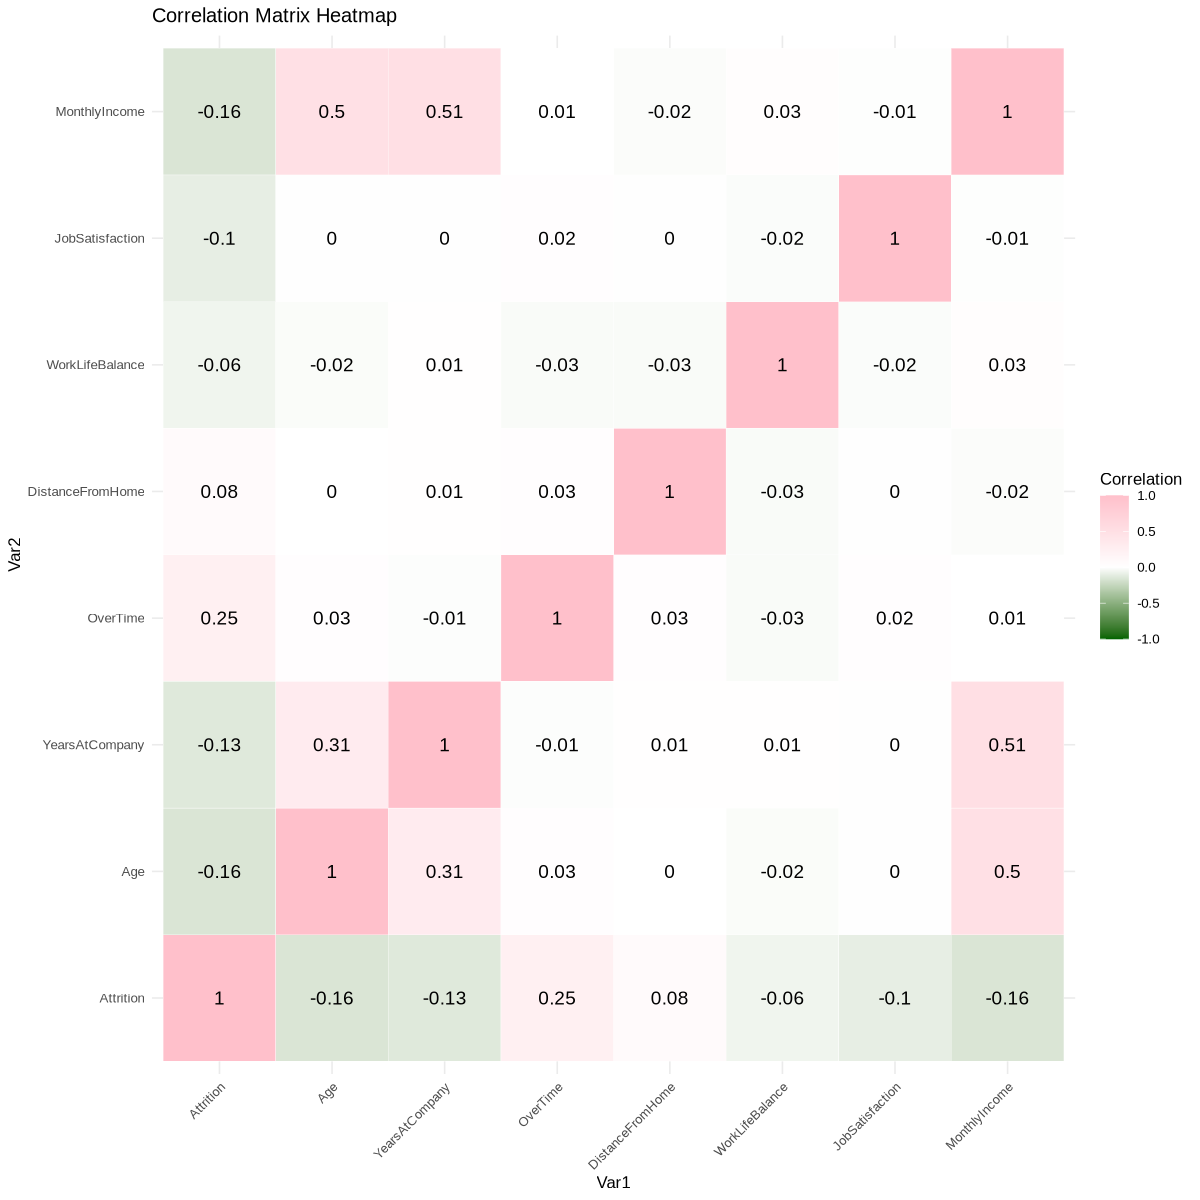

In [49]:
options(repr.plot.width = 10, repr.plot.height = 10) 
# Main: Dhawal
# Contributor: Yuko
# Convert factors to numeric and characters to numeric
matrix_data <- hr_attrition_subset %>%
  mutate(across(where(is.factor), as.numeric)) %>%
  mutate(across(where(is.character), ~ as.numeric(as.factor(.)))) 

# Compute the correlation matrix
cor_matrix <- cor(matrix_data, use = "complete.obs")

# Melt the correlation matrix for ggplot
melted_cor_matrix <- melt(cor_matrix)

# Plot the correlation matrix heatmap with numbers
corr_plot <- melted_cor_matrix %>%
    ggplot(aes(x = Var1, y = Var2, fill = value)) +
    geom_tile(color = "white") +
    scale_fill_gradient2(low = "darkgreen", mid = "white", high = "pink", 
                        midpoint = 0, limit = c(-1,1), space = "Lab", 
                        name = "Correlation") +
    theme_minimal(base_size = 10) + # Reduce base size for smaller dimensions
    theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1)) +
    labs(title = "Correlation Matrix Heatmap") +
    geom_text(aes(label = round(value, 2)), size = 4)  # Smaller text size
corr_plot

As suspected, we can see that there is multicollinearity between age, monthly income, and years at company.  We can also now especially see that work life balance and distance from home are weakly related to attrition, so we should consider removing these additional variables to allow for simplicity as we proceed with our model. 

# Methods and Implementation #

This study focuses on both inference and prediction so we will first select our covariates, then we will generate and eventually evaluate a model based on these predictors. While exploring the dataset we chose 7 variables that we suspect impact attrition. To ensure the validity of this selection, we will apply lasso regularization on a model that fits all 35 variables. We choose lasso intead of ridge regression as we suspect that many variables do not significantly impact attrition. Lasso regularization reduces the coefficients of these variables to 0, effectively performing variable selection. 

We have seen that multicollinearity is evident among the 7 selected variables, so we will refine this model as well by removing highly correlated variables. This will allow for easier interpretability of the model. Note that we prioritize simplicity in this study as this will make decision making for organizations much easier. For example, if we conclude that job satisfaction impacts attrition more than monthly income, employers will know exactly what steps to take to prevent attrition. In contrast, for life or death scenarios, the predictive performance of a model should take precedence over simplicity to prevent more serious consequences. 

Finally, a logistic model will be fitted in order to investigate the relationship between these predictors and the prevelance of employee attrition. This is the most appropriate method due to the fact that the response variable has a binary outcome ie. employee attrition is measured by either "yes" or "no." This means that if we were to try and use, say, a linear model, the range of the prediction would not be valid since the outcome of predicting attrition is a probability curve between 0 and 1, rather than some continuous value on a straight line. In this case, the additive logistic regression model can be fitted as follows: 
$$
\begin{equation*} 
\mbox{logit}(p_i) = \log\left(\frac{p_i}{1 - p_i}\right) = \beta_0 + \beta_1\text{X}_1 + \beta_2\text{X}_2 + \beta_3\text{X}_3 + ... + \beta_k\text{X}_k 
\end{equation*}
$$

Where $\text{X}_1,\text{X}_2,...,\text{X}_k$ represents the selected covariates and $\beta_1,\beta_2,...,\beta_k$ are their corresponding coefficients. This model represents the logarithm of the odds, or the ratio of the probability of success (${p_i}$) to the probability of failure (${1 - p_i}$). 

Some assumptions of a logistic regression model include the fact that the observations are independent of eachother, the log odd ratios are linearly related to the predictors, and that there is not much multicollinearity. We can say that some of these assumptions are met as the employees are not grouped in any particular way to indicate that their responses may impact eachother. Additionally, we have already checked for multicollinearity and decided to remove problematic predictors. However, as seen in the plot comparing the amount of attrition vs retention, it is evident that the rate of attrition is much lower than the rate of retention, meaning this data is not well balanced. This is a weakness of logistic regression as underfitting and overfitting are likely for models that are too complex or not complex enough. This could lead to low precision in the predicted rate of attrition on new data as the model will likely be very accurate in classifying retention but not so much in attrition.

To test the predictive power of this logistic model, a confusion matrix will be constructed detailing the precision, accuracy, sensitivity, and specificity of its predictions on an out-of-sample dataset. Then, the roc curve, as well as the area under the curve will be calculated to evaluate the models overall performance. 

## Variable Selection ##

First we split the data into training and testing subsets, then use the training data to create a LASSO regression

In [6]:
set.seed(123)

# Main: Jack
# Split into training and testing data
attrition_split <- initial_split(hr_attrition, prop = 0.75, strata = Attrition)
attrition_train <- training(attrition_split)
attrition_test <- testing(attrition_split)

# Input and response as matrices as needed by glmnet
x <- select(attrition_train,-Attrition) %>% as.matrix()
y <- attrition_train$Attrition %>% as.matrix()

# Main: Dhawal
# Perform cross validation to find best lambda, coefficients != 0
cv_lasso <- cv.glmnet(x, y, family = "binomial", alpha = 1)
beta_lasso <- coef(cv_lasso,s="lambda.min")
lasso_selected_covariates <- as_tibble(
        as.matrix(beta_lasso),
        rownames='covariate') %>%
        filter(covariate != '(Intercept)' & abs(s1) !=0) %>% 
        pull(covariate)
lasso_selected_covariates

Warning message in storage.mode(xd) <- "double":
“NAs introduced by coercion”
Warning message in storage.mode(xd) <- "double":
“NAs introduced by coercion”
Warning message in storage.mode(xd) <- "double":
“NAs introduced by coercion”
Warning message in storage.mode(xd) <- "double":
“NAs introduced by coercion”
Warning message in storage.mode(xd) <- "double":
“NAs introduced by coercion”
Warning message in storage.mode(xd) <- "double":
“NAs introduced by coercion”
Warning message in storage.mode(xd) <- "double":
“NAs introduced by coercion”
Warning message in storage.mode(xd) <- "double":
“NAs introduced by coercion”
Warning message in storage.mode(xd) <- "double":
“NAs introduced by coercion”
Warning message in storage.mode(xd) <- "double":
“NAs introduced by coercion”
Warning message in storage.mode(xd) <- "double":
“NAs introduced by coercion”
Warning message in cbind2(1, newx) %*% nbeta:
“NAs introduced by coercion”
Warning message in cbind2(1, newx) %*% nbeta:
“NAs introduced by co

[1] "Age"                      "DailyRate"               
 [3] "DistanceFromHome"         "Education"               
 [5] "EmployeeNumber"           "EnvironmentSatisfaction" 
 [7] "JobInvolvement"           "JobSatisfaction"         
 [9] "MonthlyIncome"            "MonthlyRate"             
[11] "NumCompaniesWorked"       "PercentSalaryHike"       
[13] "RelationshipSatisfaction" "StockOptionLevel"        
[15] "TotalWorkingYears"        "TrainingTimesLastYear"   
[17] "WorkLifeBalance"          "YearsAtCompany"          
[19] "YearsInCurrentRole"       "YearsSinceLastPromotion" 
[21] "YearsWithCurrManager"

**Comparing Nested Models**

Lets compare the covariate model selected by LASSO to the predictors we suspected had an impact on attrition (bar the ones that we know to be multicollinear and "overtime" since it was not chosen by LASSO) using logistic regression:

In [8]:
# Main: Dhawal
# tibble of LASSO selected variables
selected_vars <- attrition_train %>%
    select(all_of(lasso_selected_covariates), Attrition)

# Main: Yuko
# Logistic model of LASSO and eda covariates
attrition_logistic_model <- glm(Attrition ~., 
                             family = binomial, 
                             selected_vars) 

attrition_nested_model <- glm(Attrition ~ JobSatisfaction + YearsAtCompany + DistanceFromHome + WorkLifeBalance, 
                              family = binomial, 
                              data = attrition_train)

anova(attrition_nested_model, attrition_logistic_model, test = "Chisq")

Resid. Df Resid. Dev Df Deviance Pr(>Chi)    
1 1092      927.6527   NA       NA           NA
2 1064      760.4849   28 167.1678 9.238606e-22

We can see that the p value is very small so we reject the null hypothesis that the simpler model fits as well as the more complex model. We conclude that the model chosen from LASSO regularization is significantly better. 

In [9]:
# Main: Yuko 
# A closer look at the lasso selected model: 
Lasso_results <- attrition_logistic_model %>%
    tidy() %>%
    mutate(exp_est = exp(estimate)) %>%
    mutate_if(is.numeric, round, 3)
Lasso_results

term                      estimate std.error statistic p.value exp_est
1  (Intercept)                5.094   0.957      5.323    0.000   162.973
2  Age                       -0.020   0.015     -1.326    0.185     0.981
3  DailyRate                  0.000   0.000     -1.590    0.112     1.000
4  DistanceFromHome           0.036   0.012      3.112    0.002     1.037
5  Education2                 0.154   0.335      0.459    0.646     1.166
6  Education3                 0.049   0.299      0.164    0.870     1.050
7  Education4                 0.051   0.328      0.154    0.878     1.052
8  Education5                -1.012   0.820     -1.234    0.217     0.363
9  EmployeeNumber             0.000   0.000     -1.779    0.075     1.000
10 EnvironmentSatisfaction2  -0.865   0.293     -2.948    0.003     0.421
11 EnvironmentSatisfaction3  -0.836   0.265     -3.152    0.002     0.434
12 EnvironmentSatisfaction4  -0.826   0.262     -3.158    0.002     0.438
13 JobInvolvement2           -1.063   0.364     -2.921    0.003     0.345
14 JobInvolvement3           -1.256   0.340     -3.692    0.000     0.285
15 JobInvolvement4           -2.698   0.583     -4.630    0.000     0.067
16 JobSatisfaction2          -0.706   0.288     -2.449    0.014     0.494
17 JobSatisfaction3          -0.661   0.256     -2.582    0.010     0.516
18 JobSatisfaction4          -1.027   0.265     -3.878    0.000     0.358
19 MonthlyIncome              0.000   0.000     -2.356    0.018     1.000
20 MonthlyRate                0.000   0.000      0.251    0.801     1.000
21 NumCompaniesWorked         0.115   0.041      2.800    0.005     1.122
22 PercentSalaryHike         -0.021   0.026     -0.814    0.416     0.979
23 RelationshipSatisfaction2 -0.778   0.301     -2.587    0.010     0.459
24 RelationshipSatisfaction3 -0.587   0.262     -2.245    0.025     0.556
25 RelationshipSatisfaction4 -0.728   0.275     -2.649    0.008     0.483
26 StockOptionLevel1         -1.154   0.218     -5.294    0.000     0.315
27 StockOptionLevel2         -1.612   0.388     -4.157    0.000     0.199
28 StockOptionLevel3         -0.410   0.415     -0.987    0.323     0.664
29 TotalWorkingYears         -0.064   0.030     -2.109    0.035     0.938
30 TrainingTimesLastYear     -0.170   0.075     -2.261    0.024     0.844
31 WorkLifeBalance2          -0.514   0.390     -1.316    0.188     0.598
32 WorkLifeBalance3          -0.981   0.366     -2.682    0.007     0.375
33 WorkLifeBalance4          -0.748   0.443     -1.690    0.091     0.473
34 YearsAtCompany             0.126   0.040      3.179    0.001     1.134
35 YearsInCurrentRole        -0.108   0.047     -2.278    0.023     0.898
36 YearsSinceLastPromotion    0.103   0.043      2.367    0.018     1.108
37 YearsWithCurrManager      -0.168   0.047     -3.543    0.000     0.846

We can interpret the impact of these covariates using their exponentiated estimates. In this specific case, the odds are how likely an employee is to attrit compared to how unlikely it is at fixed values of the covariates. The coefficients can then be interpreted as the change in the log odds of the event as the respective variable increases by one unit, while holding the other predictors constant. Since the log odds of an event may be difficult to interpret in real situations, the exponent of the log odd coefficients can be taken to get the odds ratio, which tells us how the predictor impacts the odds of the event; If the odds ratio is greater than 1, then it will increase the odds, and if it is less than 1, it will decrease the odds. 

As we expected, variables such as job satisfaction and worklife balance decrease the odds of attrition as the ratings increase. From the log odds: as job satisfaction increases to 2 from 1, the odds of attrition decrease by 50.6%, and eventually jumps to a 64.2% decrease as job satisfaction is at the highest level. Interestingly, some variables do not behave as we expect, for example years at company has an odds ratio of 1.134, meaning with each increasing year attrition is 

Although some of the individual predictors are not statistically significant they contribute to the overall model. For example, "age" has a relatively high p-value, meaning it alone is not statistically significant but, as we hypothesized when we looked at multicollinearity, age likely impacts many other variables in the dataset that creates useful interactions for prediction. 

## A Predictive Model ##

Now that the model has been chosen, we can test its predictive power. 

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 299  48
         1  10  12
                                          
               Accuracy : 0.8428          
                 95% CI : (0.8016, 0.8784)
    No Information Rate : 0.8374          
    P-Value [Acc > NIR] : 0.4222          
                                          
                  Kappa : 0.2251          
                                          
 Mcnemar's Test P-Value : 1.184e-06       
                                          
            Sensitivity : 0.20000         
            Specificity : 0.96764         
         Pos Pred Value : 0.54545         
         Neg Pred Value : 0.86167         
             Prevalence : 0.16260         
         Detection Rate : 0.03252         
   Detection Prevalence : 0.05962         
      Balanced Accuracy : 0.58382         
                                          
       'Positive' Class : 1               
                              

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Area under the curve: 0.7691

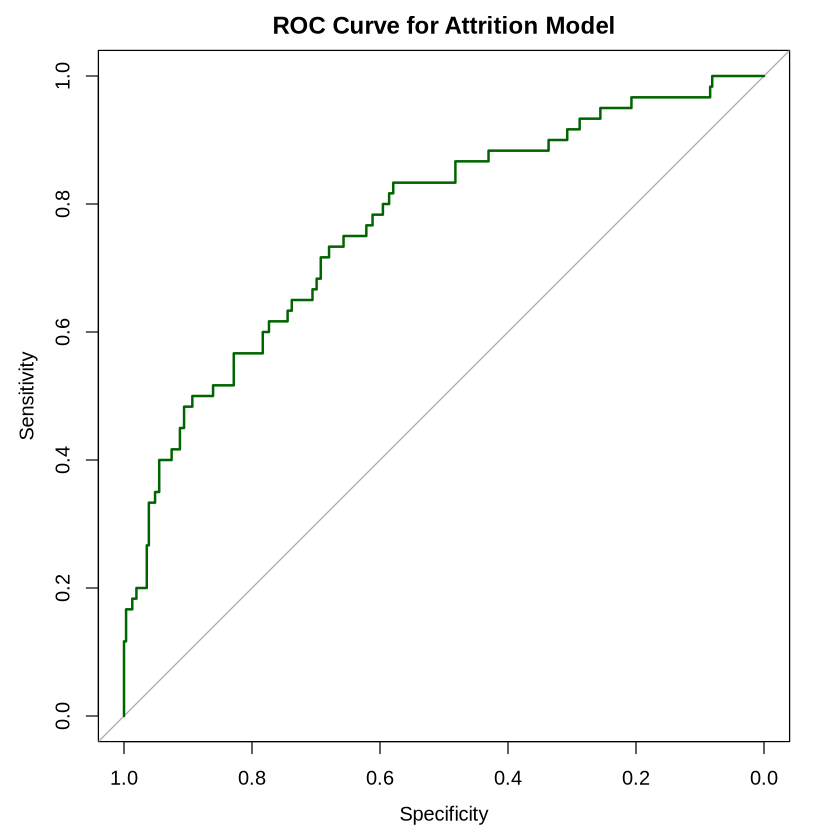

In [10]:
# Main: Jack/Dhawal/Divij 
# Predict on test data
logistic_pred_prob <- predict(attrition_logistic_model, newdata = attrition_test, type = "response")
logistic_pred_class <- as.factor(if_else(logistic_pred_prob > 0.5, "1", "0"))

# Main: Divij 
# Contributor: Dhawal, Jack
# Create a confusion matrix
logistic_confusion_matrix <- confusionMatrix(
    data = logistic_pred_class,
    reference = attrition_test$Attrition,
    positive = "1"
)
logistic_confusion_matrix

# Main: Yuko
# Contributor: Divij
# Plot the ROC curve and get AUC value
roc_curve <- roc(attrition_test$Attrition, logistic_pred_prob, positive = "1")
plot(roc_curve, col = "darkgreen", main = "ROC Curve for Attrition Model")
auc_value <- auc(roc_curve)
auc_value